In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms


from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
from torchvision.datasets import FashionMNIST
train_dataset = FashionMNIST('./data', download=True,
                                                 transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = FashionMNIST('./data', download=True,
                                                transform=transforms.Compose([transforms.ToTensor()])) # 이미지를 tensor로 변경

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size= 100)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=100)

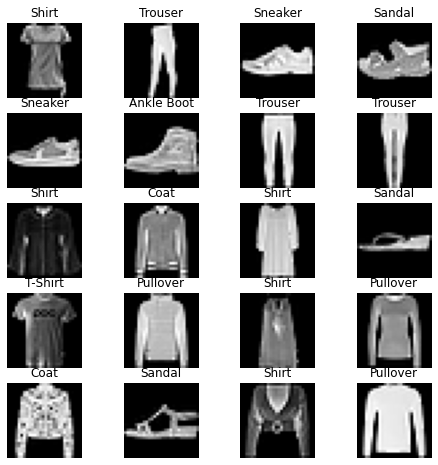

In [6]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat',
             5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows + 1) :
    img_x_y = np.random.randint(len(train_dataset))
    img = train_dataset[img_x_y][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_x_y][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

### 심층 신경망(DNN)

In [7]:
class FashionDNN(nn.Module) :
    def __init__(self) :
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features = 784, out_features = 256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features = 256, out_features = 128)
        self.fc3 = nn.Linear(in_features = 128, out_features = 10)
        
    def forward(self, input_data) :
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [8]:
lr = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
n_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

pred_list = []
label_list = []

for epoch in range(n_epochs) :
    for images, labels in train_loader :
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 50) :
            total = 0 
            correct = 0
            for images, labels in test_loader :
                images, labels = images.to(device), labels.to(device)
                label_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                pred_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not (count % 500) :
            print(f'Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy:.2f}%')
                
        

Iteration : 500, Loss : 0.5756643414497375, Accuracy : 84.50%
Iteration : 1000, Loss : 0.5257319808006287, Accuracy : 86.14%
Iteration : 1500, Loss : 0.305475115776062, Accuracy : 85.97%
Iteration : 2000, Loss : 0.3787543773651123, Accuracy : 87.06%
Iteration : 2500, Loss : 0.2722150981426239, Accuracy : 88.03%
Iteration : 3000, Loss : 0.30288562178611755, Accuracy : 88.59%


---

### 합성곱 신경망(CNN)

In [10]:
class FashionCNN(nn.Module) :
    def __init__(self) :
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential( # 입력 채널 수(in_channels) : 흑백 1, RGB 3
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10) # 클래스 개수 = 10
        
    def forward(self, x) :
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [11]:
lr = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [16]:
# train/eval model
n_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

pred_list = []
label_list = []

for epoch in range(n_epochs) :
    for images, labels in train_loader :
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 50) :
            total = 0 
            correct = 0
            for images, labels in test_loader :
                images, labels = images.to(device), labels.to(device)
                label_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                pred_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not (count % 500) :
            print(f'Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy:.2f}%')

Iteration : 500, Loss : 0.8286218047142029, Accuracy : 72.54%
Iteration : 1000, Loss : 0.766845703125, Accuracy : 72.68%
Iteration : 1500, Loss : 0.5201575756072998, Accuracy : 71.07%
Iteration : 2000, Loss : 0.7292124032974243, Accuracy : 73.14%
Iteration : 2500, Loss : 0.6765724420547485, Accuracy : 73.07%
Iteration : 3000, Loss : 0.539757490158081, Accuracy : 72.87%
